In [ ]:
# import dependencies
%matplotlib inline
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import gensim
from gensim.models import LdaModel
from gensim import models, corpora, similarities
import re
from nltk.stem.porter import PorterStemmer
import time
from nltk import FreqDist
from scipy.stats import entropy
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
df = pd.read_csv('fake.csv', usecols = ['uuid','author','title','text','language','site_url','country'])

In [ ]:
df.head()

,uuid,author,title,text,language,site_url,country
0,6a175f46bcd24d39b3e962ad0f29936721db70db,Barracuda Brigade,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,100percentfedup.com,US
1,2bdc29d12605ef9cf3f09f9875040a7113be5d5b,reasoning with facts,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,english,100percentfedup.com,US
2,c70e149fdd53de5e61c29281100b9de0ed268bc3,Barracuda Brigade,BREAKING: Weiner Cooperating With FBI On Hilla...,Red State : \nFox News Sunday reported this mo...,english,100percentfedup.com,US
3,7cf7c15731ac2a116dd7f629bd57ea468ed70284,Fed Up,PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnappe...,Email Kayla Mueller was a prisoner and torture...,english,100percentfedup.com,US
4,0206b54719c7e241ffe0ad4315b808290dbe6c0f,Fed Up,FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Heal...,Email HEALTHCARE REFORM TO MAKE AMERICA GREAT ...,english,100percentfedup.com,US


In [ ]:
df = df[df.language == 'english']
df = df[df['text'].map(type) == str]
df['title'].fillna(value="", inplace=True)
df.dropna(axis=0, inplace=True, subset=['text'])
# shuffle the data
df = df.sample(frac=1.0)
df.reset_index(drop=True,inplace=True)
df.head()

,uuid,author,title,text,language,site_url,country
0,fa90e56c54f70f8770a8dc9e0ebfd23d8e312bcc,Gilad Atzmon,Top five donors to Clinton campaign are Jewish,"Behind the headlines - conspiracies, cover-ups...",english,thetruthseeker.co.uk,GB
1,504cda23ef42182dfee390c44dab2c5023e516b8,NaN,Genetically Modified Crops in U.S. Fail to Del...,Trending Articles: Trending Articles: Genetica...,english,blacklistednews.com,US
2,66bad4341fe2bc84905daaae1e3bd951d0e4d48c,Andrew Napolitano,The Forgotten Man,Here's something interesting from The Unz Revi...,english,unz.com,US
3,6ed01d8632b965e163276ac6736f20eeffcf9bba,Contributing Author,Trump May Or May Not Be Aware Of The Plan: “A ...,This article first appeared at Personal Libert...,english,shtfplan.com,US
4,db7b7a743808f8f13116282adbe307185ae617b4,True Activist,20 Before & After Photos That Reveal The Effec...,Drinking alcohol might seem like the normal or...,english,trueactivist.com,US


In [ ]:
def initial_clean(text):
    """
    Function to clean text of websites, email addresess and any punctuation
    We also lower case the text
    """
    text = re.sub("((\S+)?(http(s)?)(\S+))|((\S+)?(www)(\S+))|((\S+)?(\@)(\S+)?)", " ", text)
    text = re.sub("[^a-zA-Z ]", "", text)
    text = text.lower() # lower case the text
    text = nltk.word_tokenize(text)
    return text

stop_words = stopwords.words('english')
def remove_stop_words(text):
    """
    Function that removes all stopwords from text
    """
    return [word for word in text if word not in stop_words]

stemmer = PorterStemmer()
def stem_words(text):
    """
    Function to stem words, so plural and singular are treated the same
    """
    try:
        text = [stemmer.stem(word) for word in text]
        text = [word for word in text if len(word) > 1] # make sure we have no 1 letter words
    except IndexError: # the word "oed" broke this, so needed try except
        pass
    return text

def apply_all(text):
    """
    This function applies all the functions above into one
    """
    return stem_words(remove_stop_words(initial_clean(text)))

In [ ]:
# clean text and title and create new column "tokenized"
t1 = time.time()
df['tokenized'] = df['text'].apply(apply_all) + df['title'].apply(apply_all)
t2 = time.time()
print("Time to clean and tokenize", len(df), "articles:", (t2-t1)/60, "min")

Time to clean and tokenize 12357 articles: 3.1582104484240214 min


In [ ]:
df['tokenized']

0        [behind, headlin, conspiraci, coverup, ancient...
1        [trend, articl, trend, articl, genet, modifi, ...
2        [here, someth, interest, unz, review, recipi, ...
3        [articl, first, appear, person, liberti, publi...
4        [drink, alcohol, might, seem, like, normal, hi...
                               ...                        
12352    [novemb, fbi, clinton, foundat, investig, high...
12353    [written, three, time, paul, ryan, presid, glo...
12354    [yemen, photo, provid, media, bureau, oper, co...
12355    [new, zealand, countri, entir, east, coast, ur...
12356    [kidney, protect, liver, protect, tabl, reveal...
Name: tokenized, Length: 12357, dtype: object

In [ ]:
# first get a list of all words
all_words = [word for item in list(df['tokenized']) for word in item]
# use nltk fdist to get a frequency distribution of all words
fdist = FreqDist(all_words)
len(fdist) # number of unique words

96280

In [ ]:
all_words

['behind',
 'headlin',
 'conspiraci',
 'coverup',
 'ancient',
 'mysteri',
 'real',
 'news',
 'perspect',
 'wont',
 'find',
 'mainstream',
 'media',
 'brows',
 'home',
 'top',
 'five',
 'donor',
 'clinton',
 'campaign',
 'jewish',
 'essenti',
 'read',
 'anglosaxon',
 'mission',
 'part',
 'ii',
 'wmwadmin',
 'march',
 'former',
 'citi',
 'london',
 'insid',
 'reveal',
 'depopul',
 'program',
 'would',
 'begin',
 'plan',
 'war',
 'israel',
 'iran',
 'importantli',
 'goe',
 'onto',
 'describ',
 'derail',
 'plan',
 'global',
 'domin',
 'come',
 'clean',
 'wmwadmin',
 'april',
 'chemtrail',
 'product',
 'conspiraci',
 'theori',
 'real',
 'get',
 'low',
 'aircraft',
 'mechan',
 'done',
 'investig',
 'us',
 'back',
 'plan',
 'launch',
 'chemic',
 'weapon',
 'attack',
 'syria',
 'blame',
 'assad',
 'govt',
 'report',
 'wmwadmin',
 'june',
 'report',
 'appear',
 'januari',
 'subsequ',
 'remov',
 'mail',
 'websit',
 'fortun',
 'observ',
 'copi',
 'extract',
 'repost',
 'advent',
 'antichrist',
 '

In [ ]:
# choose k and visually inspect the bottom 10 words of the top k
k = 50000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('scalfari', 1),
 ('barabba', 1),
 ('usdcad', 1),
 ('baidu', 1),
 ('qwerti', 1),
 ('nazarian', 1),
 ('afterglow', 1),
 ('nighthour', 1),
 ('fraudhour', 1),
 ('thecommonseonsesneshowcom', 1)]

In [ ]:
# choose k and visually inspect the bottom 10 words of the top k
k = 15000
top_k_words = fdist.most_common(k)
top_k_words[-10:]

[('disempower', 13),
 ('thighborg', 13),
 ('kickoff', 13),
 ('ecommerc', 13),
 ('charlottesvil', 13),
 ('hypnotist', 13),
 ('cpd', 13),
 ('diagram', 13),
 ('archuleta', 13),
 ('deepleftfieldinfo', 13)]

In [ ]:
# define a function only to keep words in the top k words
top_k_words,_ = zip(*fdist.most_common(k))
top_k_words = set(top_k_words)
def keep_top_k_words(text):
    return [word for word in text if word in top_k_words]

In [ ]:
df['tokenized'] = df['tokenized'].apply(keep_top_k_words)

In [ ]:
df['tokenized']

0        [behind, headlin, conspiraci, coverup, ancient...
1        [trend, articl, trend, articl, genet, modifi, ...
2        [here, someth, interest, unz, review, recipi, ...
3        [articl, first, appear, person, liberti, publi...
4        [drink, alcohol, might, seem, like, normal, hi...
                               ...                        
12352    [novemb, fbi, clinton, foundat, investig, high...
12353    [written, three, time, paul, ryan, presid, glo...
12354    [yemen, photo, provid, media, bureau, oper, co...
12355    [new, zealand, countri, entir, east, coast, ur...
12356    [kidney, protect, liver, protect, tabl, reveal...
Name: tokenized, Length: 12357, dtype: object

In [ ]:
# document length
df['doc_len'] = df['tokenized'].apply(lambda x: len(x))
print(df['doc_len'].head())
doc_lengths = list(df['doc_len'])
df.drop(labels='doc_len', axis=1, inplace=True)

print("length of list:",len(doc_lengths),
      "\naverage document length", np.average(doc_lengths),
      "\nminimum document length", min(doc_lengths),
      "\nmaximum document length", max(doc_lengths))

0     248
1     207
2     435
3    1106
4      27
Name: doc_len, dtype: int64
length of list: 12357 
average document length 345.66828518248764 
minimum document length 0 
maximum document length 11578


In [ ]:
df.head(2)

,uuid,author,title,text,language,site_url,country,tokenized
0,fa90e56c54f70f8770a8dc9e0ebfd23d8e312bcc,Gilad Atzmon,Top five donors to Clinton campaign are Jewish,"Behind the headlines - conspiracies, cover-ups...",english,thetruthseeker.co.uk,GB,"[behind, headlin, conspiraci, coverup, ancient..."
1,504cda23ef42182dfee390c44dab2c5023e516b8,NaN,Genetically Modified Crops in U.S. Fail to Del...,Trending Articles: Trending Articles: Genetica...,english,blacklistednews.com,US,"[trend, articl, trend, articl, genet, modifi, ..."


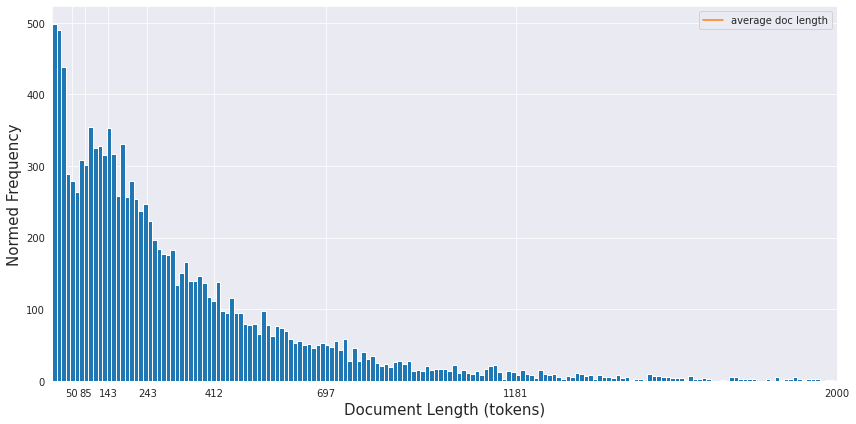

In [ ]:
# plot a histogram of document length
num_bins = 1000
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
n, bins, patches = ax.hist(doc_lengths, num_bins)
ax.set_xlabel('Document Length (tokens)', fontsize=15)
ax.set_ylabel('Normed Frequency', fontsize=15)
ax.grid()
ax.set_xticks(np.logspace(start=np.log10(50),stop=np.log10(2000),num=8, base=10.0))
plt.xlim(0,2000)
ax.plot([np.average(doc_lengths) for i in np.linspace(0.0,0.0035,100)], np.linspace(0.0,0.0035,100), '-',
        label='average doc length')
ax.legend()
ax.grid()
fig.tight_layout()
plt.show()

In [ ]:
# only keep articles with more than 30 tokens, otherwise too short
df = df[df['tokenized'].map(len) >= 40]
# make sure all tokenized items are lists
df = df[df['tokenized'].map(type) == list]
df.reset_index(drop=True,inplace=True)
print("After cleaning and excluding short aticles, the dataframe now has:", len(df), "articles")

After cleaning and excluding short aticles, the dataframe now has: 10812 articles


In [ ]:
# create a mask of binary values
msk = np.random.rand(len(df)) < 0.999

In [ ]:
msk

array([ True,  True,  True, ...,  True,  True,  True])

In [ ]:
train_df = df[msk]
train_df.reset_index(drop=True,inplace=True)

test_df = df[~msk]
test_df.reset_index(drop=True,inplace=True)

In [ ]:
train_df.head(2)

,uuid,author,title,text,language,site_url,country,tokenized
0,fa90e56c54f70f8770a8dc9e0ebfd23d8e312bcc,Gilad Atzmon,Top five donors to Clinton campaign are Jewish,"Behind the headlines - conspiracies, cover-ups...",english,thetruthseeker.co.uk,GB,"[behind, headlin, conspiraci, coverup, ancient..."
1,504cda23ef42182dfee390c44dab2c5023e516b8,NaN,Genetically Modified Crops in U.S. Fail to Del...,Trending Articles: Trending Articles: Genetica...,english,blacklistednews.com,US,"[trend, articl, trend, articl, genet, modifi, ..."


In [ ]:
print(len(df),len(train_df),len(test_df))

10812 10807 5


In [ ]:
def train_lda(data):
    """
    This function trains the lda model
    We setup parameters like number of topics, the chunksize to use in Hoffman method
    We also do 2 passes of the data since this is a small dataset, so we want the distributions to stabilize
    """
    num_topics = 100
    chunksize = 300
    dictionary = corpora.Dictionary(data['tokenized'])
    corpus = [dictionary.doc2bow(doc) for doc in data['tokenized']]
    t1 = time.time()
    # low alpha means each document is only represented by a small number of topics, and vice versa
    # low eta means each topic is only represented by a small number of words, and vice versa
    lda = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary,
                   alpha=1e-2, eta=0.5e-2, chunksize=chunksize, minimum_probability=0.0, passes=2)
    t2 = time.time()
    print("Time to train LDA model on ", len(df), "articles: ", (t2-t1)/60, "min")
    return dictionary,corpus,lda

In [ ]:
dictionary,corpus,lda = train_lda(train_df)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


Time to train LDA model on  10812 articles:  1.400085484981537 min


In [ ]:
lda.show_topics(num_topics=10, num_words=20)

[(91,
  '0.030*"inform" + 0.027*"use" + 0.025*"compani" + 0.023*"facebook" + 0.017*"data" + 0.017*"websit" + 0.016*"site" + 0.014*"googl" + 0.013*"internet" + 0.012*"page" + 0.012*"user" + 0.011*"comput" + 0.011*"network" + 0.011*"access" + 0.010*"onlin" + 0.010*"technolog" + 0.009*"us" + 0.009*"provid" + 0.008*"post" + 0.008*"servic"'),
 (32,
  '0.280*"andrew" + 0.245*"art" + 0.137*"jeffrey" + 0.074*"wine" + 0.048*"consult" + 0.039*"music" + 0.034*"bradford" + 0.025*"connect" + 0.013*"fifa" + 0.013*"tournament" + 0.009*"food" + 0.006*"member" + 0.004*"deepleftfieldinfo" + 0.003*"cup" + 0.001*"pierson" + 0.000*"say" + 0.000*"al" + 0.000*"england" + 0.000*"said" + 0.000*"use"'),
 (4,
  '0.227*"contact" + 0.206*"pleas" + 0.134*"email" + 0.073*"subscrib" + 0.052*"donat" + 0.041*"address" + 0.041*"receiv" + 0.030*"blog" + 0.016*"get" + 0.016*"new" + 0.014*"post" + 0.012*"dive" + 0.011*"via" + 0.009*"run" + 0.007*"nake" + 0.007*"keep" + 0.007*"monthli" + 0.007*"notifi" + 0.006*"tame" + 0.00

In [ ]:
lda.show_topic(topicid=4, topn=20)

[('immigr', 0.13580014),
 ('illeg', 0.08208348),
 ('alien', 0.03803958),
 ('mexico', 0.03739274),
 ('border', 0.03235925),
 ('wall', 0.026419984),
 ('countri', 0.024081625),
 ('jerusalem', 0.020093756),
 ('america', 0.01568658),
 ('deport', 0.014938081),
 ('texa', 0.01457519),
 ('american', 0.014553388),
 ('unit', 0.013025045),
 ('secur', 0.012581443),
 ('build', 0.012546874),
 ('citi', 0.012440706),
 ('plan', 0.012006148),
 ('us', 0.011422619),
 ('move', 0.009314171),
 ('cross', 0.008794419)]

In [ ]:
lda.show_topic(topicid=85, topn=20)

[('earth', 0.026727475),
 ('star', 0.018808242),
 ('planet', 0.014275188),
 ('space', 0.014245245),
 ('light', 0.013384292),
 ('alien', 0.0130836135),
 ('discoveri', 0.009276148),
 ('ancient', 0.009180628),
 ('appear', 0.008762714),
 ('origin', 0.00874469),
 ('sun', 0.008427799),
 ('mysteri', 0.008408482),
 ('look', 0.008274684),
 ('around', 0.0076543945),
 ('nasa', 0.0076509058),
 ('dna', 0.007079556),
 ('discard', 0.00702118),
 ('found', 0.006812178),
 ('sky', 0.006785772),
 ('fascin', 0.006726354)]

In [ ]:
# select and article at random from train_df
random_article_index = np.random.randint(len(train_df))
bow = dictionary.doc2bow(train_df.iloc[random_article_index,7])
print(random_article_index)

1590


In [ ]:
print(train_df.iloc[random_article_index,3])

Wife of FBI Official Investigating Hillary Got $500K from Hillary Allied PAC October 27, 2016 Daniel Greenfield 
The system is broken. It's deeply corrupted by insider politics . The situation at the center of power has reached the point of utter unaccountability. Insider politics function as a shadow government. That needs to change. Restoring America requires dismantling much of the Federal government not only for Constitutional reasons, but because it's a simple matter of saving the Republic. 
Hillary Clinton headlined a major fundraiser for a political action committee shortly before the group steered nearly $500,000 to the wife of the FBI official who oversaw the Clinton email investigation, DailyMail.com has learned. 
Clinton's ties to the Common Good VA - a Virginia state PAC run by Clinton's long-time friend and advisor Terry McAuliffe, its governor - came under scrutiny this week after the Wall Street Journal reported that the group donated heavily to the state senate campaign

In [ ]:
# get the topic contributions for the document chosen at random above
doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=bow)])

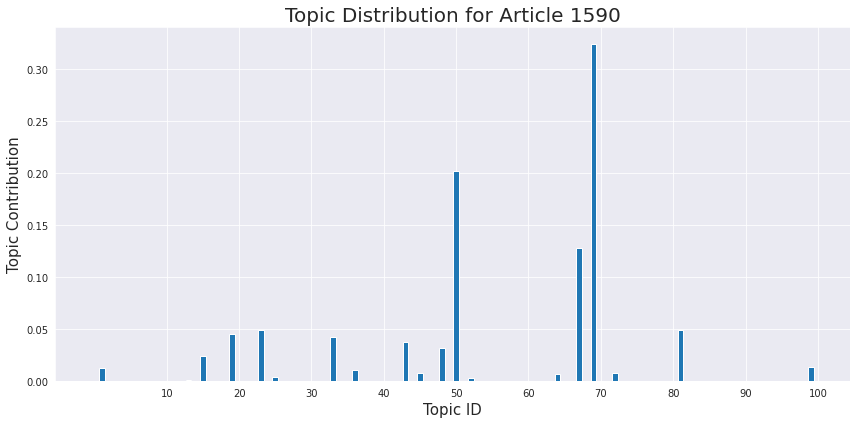

In [ ]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(doc_distribution)), doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for Article " + str(random_article_index), fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [ ]:
# print the top 5 contributing topics and their words
for i in doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

87 [('go', 0.020807778), ('peopl', 0.020450788), ('get', 0.019537073), ('like', 0.01756642), ('dont', 0.015148101), ('know', 0.015074524), ('think', 0.014208449), ('make', 0.012825399), ('one', 0.012151202), ('thing', 0.0120570725)] 

84 [('bank', 0.0240109), ('money', 0.022062615), ('year', 0.015560724), ('economi', 0.013597088), ('financi', 0.013291504), ('dollar', 0.011419494), ('billion', 0.011026669), ('tax', 0.01059189), ('us', 0.01048846), ('govern', 0.009826682)] 

7 [('trump', 0.152107), ('donald', 0.04493652), ('clinton', 0.031095121), ('elect', 0.028443713), ('presid', 0.026638107), ('vote', 0.026094237), ('hillari', 0.020005828), ('parti', 0.014145356), ('go', 0.013580612), ('american', 0.012829793)] 

12 [('immigr', 0.04865034), ('obama', 0.039913412), ('american', 0.038686186), ('countri', 0.032781735), ('america', 0.029710853), ('illeg', 0.029665204), ('unit', 0.017744327), ('us', 0.01748673), ('border', 0.016501611), ('presid', 0.015625192)] 

39 [('year', 0.013830685),

In [ ]:
# select and article at random from test_df
random_article_index = np.random.randint(len(test_df))
print(random_article_index)

2


In [ ]:
new_bow = dictionary.doc2bow(test_df.iloc[random_article_index,7])

In [ ]:
print(test_df.iloc[random_article_index,3])

BLM Rapper & Bill’s Alleged Son Have Nasty Surprise For Hillary Posted on October 31, 2016 by Rebecca Diserio in Politics Share This 
It looks like when it rains, it pours, and Hillary Clinton is now facing a big problem with Black Lives Matter. It all stems from an alleged affair Bill Clinton had with a black Arkansas prostitute, which produced a son. Now, after years of trying to find out the truth about his biological father, the rumored son’s cause is being taken up by a black rapper, and they have a really bad surprise for Hillary. Rapper “Freenauts” wears “Hillary for Prison” t-shirt while performing rap song “Justice For Danney Williams” 
The BLM rapper “Freenauts,” wearing a “Hillary for Prison” t-shirt, put out a video, performing his rap song “Justice for Danney Williams,” referring to Bill Clinton’s alleged lovechild. The video has just over 100,000 views, but now that it is the last week before the election, Donald Trump supporters, as well as Black Lives Matter supporters,

In [ ]:
new_doc_distribution = np.array([tup[1] for tup in lda.get_document_topics(bow=new_bow)])

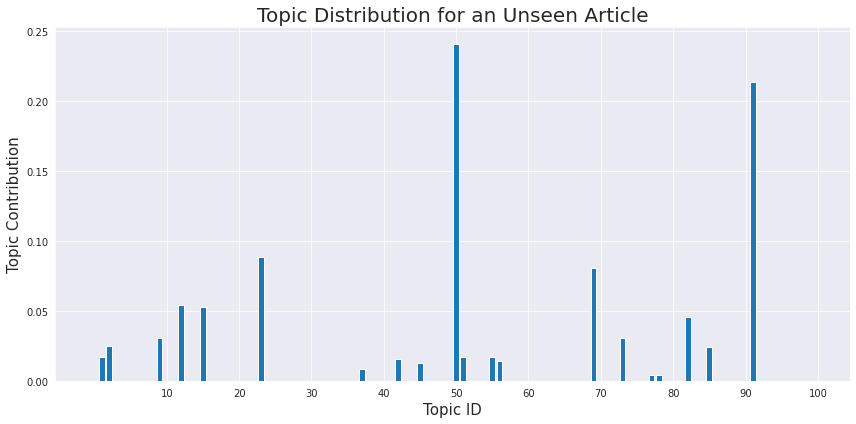

In [ ]:
# bar plot of topic distribution for this document
fig, ax = plt.subplots(figsize=(12,6));
# the histogram of the data
patches = ax.bar(np.arange(len(new_doc_distribution)), new_doc_distribution)
ax.set_xlabel('Topic ID', fontsize=15)
ax.set_ylabel('Topic Contribution', fontsize=15)
ax.set_title("Topic Distribution for an Unseen Article", fontsize=20)
ax.set_xticks(np.linspace(10,100,10))
fig.tight_layout()
plt.show()

In [ ]:
# print the top 8 contributing topics and their words
for i in new_doc_distribution.argsort()[-5:][::-1]:
    print(i, lda.show_topic(topicid=i, topn=10), "\n")

50 [('clinton', 0.15779713), ('hillari', 0.119718954), ('campaign', 0.03171431), ('foundat', 0.023470638), ('leak', 0.016569931), ('presid', 0.016207939), ('tape', 0.015889456), ('email', 0.014757314), ('bill', 0.014661247), ('wikileak', 0.012536128)] 

91 [('said', 0.017356016), ('year', 0.012523704), ('day', 0.011745965), ('one', 0.011442394), ('time', 0.009659199), ('famili', 0.008830527), ('two', 0.00882977), ('told', 0.008398595), ('home', 0.008368804), ('man', 0.007397914)] 

23 [('like', 0.022248425), ('go', 0.021411374), ('get', 0.02087955), ('dont', 0.020218393), ('know', 0.016116602), ('think', 0.015090104), ('peopl', 0.014795168), ('make', 0.014096708), ('want', 0.014073825), ('say', 0.014001077)] 

69 [('email', 0.021601206), ('hillari', 0.018955154), ('clinton', 0.01761525), ('comey', 0.016653033), ('investig', 0.016583482), ('elect', 0.01605892), ('fbi', 0.01321778), ('depart', 0.012625657), ('justic', 0.01136352), ('director', 0.010474315)] 

12 [('black', 0.28207785), (

In [ ]:
doc_topic_dist = np.array([[tup[1] for tup in lst] for lst in lda[corpus]])
doc_topic_dist.shape

(10807, 100)

In [ ]:
from scipy.spatial import distance

def jensen_shannon(query, matrix):
    """
    This function implements a Jensen-Shannon similarity
    between the input query (an LDA topic distribution for a document)
    and the entire corpus of topic distributions.
    """
    sim = [distance.jensenshannon(data,query) for data in matrix]
    return np.array(sim)

In [ ]:
def get_most_similar_documents(query,matrix,k=10):
    """
    This function implements the Jensen-Shannon distance above
    and retruns the top k indices of the smallest jensen shannon distances
    """
    sims = jensen_shannon(query,matrix) # list of jensen shannon distances
    return sims.argsort()[:k] # the top k positional index of the smallest Jensen Shannon distances

In [ ]:
# this is surprisingly fast
most_sim_ids = get_most_similar_documents(new_doc_distribution,doc_topic_dist)

In [ ]:
doc_topic_dist

array([[4.0160641e-05, 4.0160641e-05, 4.0160641e-05, ..., 4.0160641e-05,
        4.0160641e-05, 4.0160641e-05],
       [4.8076930e-05, 4.8076930e-05, 4.8076930e-05, ..., 4.8076930e-05,
        4.8076930e-05, 4.8076930e-05],
       [2.2935779e-05, 4.9521559e-01, 2.2935779e-05, ..., 2.2935779e-05,
        5.3245649e-02, 2.2935779e-05],
       ...,
       [4.8543683e-05, 4.8543683e-05, 4.8543683e-05, ..., 4.8543683e-05,
        4.8543683e-05, 4.8543683e-05],
       [1.1904762e-04, 1.1904762e-04, 1.1904762e-04, ..., 1.1904762e-04,
        1.1904762e-04, 1.1904762e-04],
       [8.8928323e-03, 3.7569734e-03, 2.9761904e-05, ..., 1.3958849e-02,
        2.9761904e-05, 2.9761904e-05]], dtype=float32)

In [ ]:
new_doc_distribution


array([3.71747192e-05, 1.68214031e-02, 2.51489282e-02, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.03529501e-02, 3.71747192e-05, 3.71747192e-05,
       5.38441837e-02, 3.71747192e-05, 3.71747192e-05, 5.30044474e-02,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 8.82279724e-02,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 8.56371876e-03, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 1.58829186e-02, 3.71747192e-05,
       3.71747192e-05, 1.27149737e-02, 3.71747192e-05, 3.71747192e-05,
       3.71747192e-05, 3.71747192e-05, 2.40660027e-01, 1.71151385e-02,
       3.71747192e-05, 3.71747192e-05, 3.71747192e-05, 1.72882266e-02,
      

In [ ]:
most_sim_ids

array([1254,  429, 2605, 1425, 8361, 8227, 1940, 9817, 5615, 2826])

In [ ]:
most_similar_df = train_df[train_df.index.isin(most_sim_ids)]
most_similar_df['title']

429     Clinton Campaign In FULL PANIC After Bill’s Al...
1254    Clinton Campaign In FULL PANIC After Bill’s Al...
1425    Hillary Immediately Runs From Media After What...
1940    Hillary Clinton celebrates her birthday on Spa...
2605    WATCH: Trump Calls CNN Reporter “Rude” For Que...
2826    New Alleged Audio: Bill Clinton Encourages Mis...
5615    We Finally Know Why Hillary Disappeared On Ele...
8227    VIDEO: Proof Hillary’s Frail Health is Becomin...
8361    Hillary Makes SCANDALOUS Stop After Rachel Mad...
9817    Bill Clinton`s long-time lover reveals how he ...
Name: title, dtype: object